# CR3BP low-thrust

In this tutorial we show the use of the {class}`pykep.trajopt.direct_cr3bp` to find a low-thrust (zero-order hold continuous thrust) trajectory connecting two orbits in the circular restricted 3-body problem (CR3BP). 

The decision vector for this class, compatible with pygmo {cite:p}`pagmo` UDPs (User Defined Problems), is:

$$
\mathbf x = [t_0, m_f, V_{sx}^\infty, V^\infty_{sy}, V^\infty_{sz}, V^\infty_{fx}, V^\infty_{fy}, V^\infty_{fz}, u_{x0}, u_{y0}, u_{z0}, u_{x1}, u_{y1}, u_{z1}, ..., T_{tof}]
$$

containing the starting epoch $t_0=0$, the final mass $m_f$ as well as the starting and final $V^{\infty}$, throttles and the time-of-flight $T_{tof}$.

:::{note}
This notebook makes use of the commercial solver SNOPT 7 and to run needs a valid `snopt_7_c` library installed in the system. In case SNOPT7 is not available, you can still run the notebook using, for example `uda = pg.algorithm.nlopt("slsqp")` with minor modifications.

Basic imports:

In [73]:
import pykep as pk
import numpy as np
import time
import pygmo as pg
import pygmo_plugins_nonfree as ppnf
import time

from matplotlib import pyplot as plt

We start defining the problem data. For the purpose of this simple notebook we choose a simple Earth to Mars transfer.

In [74]:
import json
import os

# Id to load
# ID = 0 # Yuri No Mass
# ID = 0, 1, 2, 3, 4, 5, 6, 7 # Laurant No Mass
ID = 3 # 0, 1, 2, 3 # Yuri Mass

results_file = '/Users/harry.holt/Documents/PostDoc_ACT/GTOC/benchmark-astrodynamics-sqp-scp/cr3bp_fixed_time_rdv/harry_results/'
results_name = f'yuri_mass_alpha/id{ID}_sf_nd_const'
# results_name = f'yuri_mass_alpha_free/id{ID}_sf_nd_const'

# 1. Create initial folder
folder_name = results_file + results_name
if not os.path.exists(folder_name):
    os.makedirs(folder_name)
print(f"Created folder: {folder_name}")

# Load JSON file
# with open("/Users/harry.holt/Documents/PostDoc_ACT/GTOC/benchmark-astrodynamics-sqp-scp/cr3bp_fixed_time_rdv/instances.json", "r") as f:
# with open("/Users/harry.holt/Documents/PostDoc_ACT/GTOC/benchmark-astrodynamics-sqp-scp/cr3bp_fixed_time_rdv/instances_lb.json", "r") as f:
with open("/Users/harry.holt/Documents/PostDoc_ACT/GTOC/benchmark-astrodynamics-sqp-scp/cr3bp_fixed_time_rdv/instances_ys_mass.json", "r") as f:
    data = json.load(f)

# Problem data
mu = pk.MU_MOON / (pk.MU_EARTH + pk.MU_MOON)

# Example masses (you can adjust logic if they differ)
ms = 1.0
mf = 0.5

for k, v in data.items():
    if int(k) == int(ID):
        tof = v["tspan"][1]
        
        # Initial state
        x0 = v["x0"]
        rs = np.array(x0[0:3])
        vs = np.array(x0[3:6])
        period0 = v["period0"]
        
        # Final state
        xf = v["xf"]
        rf = np.array(xf[0:3])
        vf = np.array(xf[3:6])
        periodf = v["periodf"]

        # ISPs
        c1 = v["c1"]
        c2 = v["c2"]
        tspan = [0.0, tof]

# Assign parameters
max_thrust = c1
veff = c2

# Other parameters
mu = pk.MU_MOON / (pk.MU_EARTH + pk.MU_MOON)

# Initial guess
lambda_init = np.array([1]*8)
lambda_init = (np.array(x0) - np.array(xf)).tolist() + [1, 1]

# # Check the Lyapunov compiled function
# lambda_dV_dx = dV_dx_cf(np.hstack([x0, [m0], xf]), pars=[mu])
# lambda_init = lambda_dV_dx.tolist() + [1, 1]

eps = 1e-1
lambda0 = lambda_init[-1]

print('lambda_init: ', lambda_init)

Created folder: /Users/harry.holt/Documents/PostDoc_ACT/GTOC/benchmark-astrodynamics-sqp-scp/cr3bp_fixed_time_rdv/harry_results/yuri_mass_alpha/id3_sf_nd_const
lambda_init:  [0.26654273978083165, 0.0, -0.11145303634437023, 0.0, -0.6778309185391602, 0.0, 1, 1]


In [75]:
# Throttles and cuts
nseg = 8
nseg_max = 8
cut = 0.6

In [76]:
# Normalise
L = 384400e3
TIME = np.sqrt(L**3 / (pk.MU_EARTH+pk.MU_MOON))
VEL = L / TIME
ACC = VEL / TIME
MASS = ms

print(f'Normalise L {L:.4f} T {TIME:.4f} V {VEL:.4f} M {MASS:.4f}')

# Problem data
# mu already in non-dimensional units
# max_thrust = max_thrust / (MASS * L / TIME**2)
# veff = veff / VEL

# Initial state
ms = ms / MASS
# rs already in non-dimensional units
# vs already in non-dimensional units

# Final state
mf = mf / MASS
# rf already in non-dimensional units
# vf already in non-dimensional units

# tof
# tof = tof / TIME
# tof already in non-dimensional units

Normalise L 384400000.0000 T 375190.2619 V 1024.5468 M 1.0000


Convert final position and velocity into an orbit

In [77]:
posvel0 = [
    rs.tolist(),
    vs.tolist()
]

# Propagate backwards to t0
ta = pk.ta.get_cr3bp(1e-16)
ta.pars[0] = mu
ta.time = tof
ta.state[:6] = rf.tolist() + vf.tolist()

tgrid = np.linspace(tof,0.0,10)
sol = ta.propagate_grid(tgrid)
integration = sol[5]

rf_0 = integration[-1,:3]
vf_0 = integration[-1,3:6]

posvelf = [
    rf_0.tolist(),
    vf_0.tolist()
]

print(f'IC {rf_0} {vf_0} t {ta.time}')
print(f'FC {rf} {vf} {tof}')


IC [ 0.95170684  0.0883385   0.        ] [ 0.39081263  0.18632513  0.        ] t 0.0
FC [ 0.89833535  0.          0.        ] [ 0.          0.47591169  0.        ] 5.0


We here instantiate two different versions of the same udp_alpha (User Defined Problem), with analytical gradients and without. 

For the purpose of this simple notebook we choose a relatively simple Earth to Mars transfer with an initial $V_{\infty}$ of 3 km/s.

In [78]:
ta = pk.ta.get_zero_hold_cr3bp(1e-16)
ta_var = pk.ta.get_zero_hold_cr3bp_var(1e-16)

In [79]:
udp = pk.trajopt.direct_nd(
        pls=posvel0,
        plf=posvelf,
        ms=ms,
        mu=mu,
        max_thrust=max_thrust,
        veff=veff,
        t0_bounds=[0.0, 0.0],
        tof_bounds=[tof,tof],
        mf_bounds=[ms*0.5, ms],
        vinfs=0.,
        vinff=0.,
        nseg=nseg,
        cut=cut,
        with_gradient=False,
        high_fidelity=True,
        tas = (ta, ta_var)
)

udp_alpha = pk.trajopt.direct_nd_alpha(
        pls=posvel0,
        plf=posvelf,
        ms=ms,
        mu=mu,
        max_thrust=max_thrust,
        veff=veff,
        t0_bounds=[0.0, 0.0],
        tof_bounds=[tof,tof],
        mf_bounds=[ms*0.5, ms],
        vinfs=0.,
        vinff=0.,
        nseg=nseg,
        cut=cut,
        with_gradient=False,
        high_fidelity=True,
        tas = (ta, ta_var)
)

## Solving the low-thrust transfer

We define (again) the optimization problem, and set a tolerance for *pagmo* to be able to judge the relative value of two individuals. 

In [80]:
prob = pg.problem(udp)
prob.c_tol = 1e-6
pop_g = pg.population(prob, 1)

prob_alpha = pg.problem(udp_alpha)
prob_alpha.c_tol = 1e-6
pop_alpha = pg.population(prob_alpha, 1)

... and we define an optimization algorithm.

In [81]:
snopt72 = "/Users/harry.holt/opt/libsnopt7_c.dylib"
uda = ppnf.snopt7(library=snopt72, minor_version=2, screen_output=False)
uda.set_integer_option("Major iterations limit", 2000)
uda.set_integer_option("Iterations limit", 20000)
uda.set_numeric_option("Major optimality tolerance", 1e-3)
uda.set_numeric_option("Major feasibility tolerance", 1e-8)

algo = pg.algorithm(uda)

First we will solve the constant segment optimisation, and confirm that this gives the same solution as with alpha, where alpha is forced to give constant segments

In [82]:
print('--------------------------')
print(f'Testing Nseg {nseg}')
total_time = 0.0

ntotal = 10
errs = []
obj = []
xs = []
successes = []
average_time = []

for i in range(ntotal):
    time_start = time.time()

    pop_g = pg.population(prob, 1)
    
    pop_g = algo.evolve(pop_g)
    
    time_end = time.time()
    average_time.append(time_end - time_start)
    total_time += time_end - time_start
    
    # print('err', np.linalg.norm(pop_g.champion_f[1:]), np.linalg.norm(pop_g.champion_f[1:4]), np.linalg.norm(pop_g.champion_f[4:7]))
    if(prob.feasibility_f(pop_g.champion_f)):
        print(".", end="")
        obj.append(pop_g.champion_x[1])
        xs.append(pop_g.champion_x)
        successes.append(1)
        # if nseg != nseg_old:
        #     break
    else:
        print("x", end ="")

if len(obj)>0:
    print("\nBest mass is: ", np.max(obj))
    print(f"Total time to success: {total_time:.3f} seconds")
    print(f"mean time {np.mean(np.array(average_time)):.4g} s")
    print(f"median time {np.median(np.array(average_time)):.4g} s")
    print(f"std time {np.std(np.array(average_time)):.4g} s")
    best_idx = np.argmax(obj)
else:
    xs = [pop_g.champion_x]
    best_idx = 0
    successes.append(0)
    obj.append(np.nan)
    print("\nNo solution found")

best_x = xs[best_idx]

--------------------------
Testing Nseg 8
x.....x.x.
Best mass is:  0.959630654754
Total time to success: 34.156 seconds
mean time 3.416 s
median time 1.715 s
std time 5.283 s


Visualise the result

Text(0.5, 0, 'z')

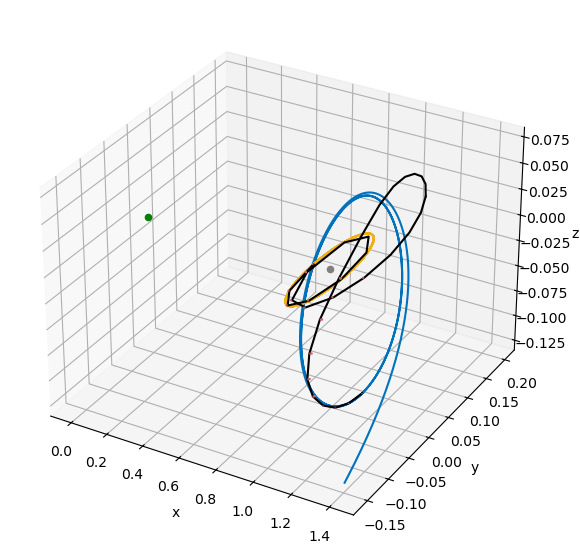

In [83]:
ax = udp.plot(best_x, show_gridpoints=False, show_throttles=True, show_midpoints=False)
# Making the axes nicer
ax.scatter(-mu, 0, 0, c="green", s=20)
ax.scatter(1-mu, 0, 0, c="gray", s=20)
# ax.set_xlim(-0.1,1.1)
# ax.set_ylim(-1/2,1/2)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
# ax.view_init(90,-90)
# ax.axis('off');


### Convert from constant segments to alpha encoding

In [84]:
# Add constant segements
best_alpha = [0.0] * (8+nseg+nseg*3+1)
# Add constant segements
best_alpha[0:8] = best_x[0:8]
best_alpha[8:8+nseg] = pk.direct2alpha([1/nseg]*nseg)[0]
best_alpha[8+nseg:] = best_x[8:]

print('best_x: ', best_x)
print('best_alpha: ', best_alpha)

best_x:  [  0.00000000e+00   9.59630655e-01   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
  -6.93060554e-03   5.67148269e-04  -7.84741456e-03  -7.27564390e-03
   7.59351346e-02  -2.57052393e-02  -1.91131995e-07   1.18372455e-08
   3.88812204e-07   2.34184208e-08  -4.08803920e-07   4.33379216e-07
   2.91652747e-02  -4.97845293e-02   2.36648951e-02   1.59438966e-06
  -7.26614026e-06  -2.17237408e-06  -1.90763956e-02  -3.90008544e-02
   1.22543608e-02  -4.62130347e-06  -6.73405403e-07  -1.14315269e-06
   5.00000000e+00]
best_alpha:  [0.0, 0.95963065475413822, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.8824969025845955, 0.8824969025845955, 0.8824969025845955, 0.8824969025845955, 0.8824969025845955, 0.8824969025845955, 0.8824969025845955, 0.8824969025845955, -0.0069306055436139319, 0.00056714826884540868, -0.007847414563609682, -0.0072756439045524928, 0.075935134630677872, -0.02570523931419692, -1.9113199450399368e-07, 1.1837245501516201e-08, 3.

Text(0.5, 0, 'z')

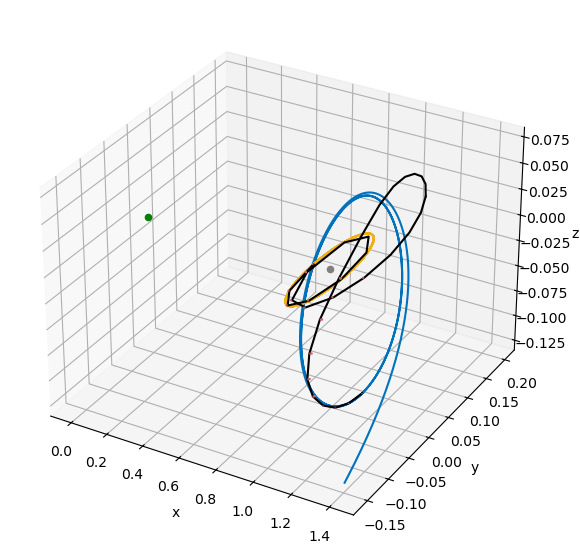

In [85]:
# Plot
ax = udp_alpha.plot(best_alpha, show_gridpoints=False, show_throttles=True, show_midpoints=False)
# Making the axes nicer
ax.scatter(-mu, 0, 0, c="green", s=20)
ax.scatter(1-mu, 0, 0, c="gray", s=20)
# ax.set_xlim(-0.1,1.1)
# ax.set_ylim(-1/2,1/2)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
# ax.view_init(90,-90)
# ax.axis('off');

We solve the problem from random initial guess ten times and only save the result if a feasible solution is found (as defined by the criterias above)

In [86]:
nseg_old = nseg

In [87]:
pop_alpha.champion_x

array([ 0.        ,  0.62398334, -0.        , -0.        , -0.        ,
       -0.        , -0.        , -0.        ,  0.81263686,  0.70910343,
        0.69464178,  0.85977626,  0.75834946,  0.83851436,  0.65108843,
        0.8072223 ,  0.56611458,  0.83556626,  0.14830579,  0.23325523,
       -0.69510103, -0.79974983, -0.65839226,  0.85434862,  0.40820356,
       -0.47616262,  0.25832302,  0.51805653, -0.58106376, -0.57598803,
       -0.35498743, -0.89776566,  0.33701818, -0.65028035, -0.76681624,
       -0.39798502, -0.19609373,  0.05351848,  0.60403909,  0.60390294,
        5.        ])

# Now convert to a higher number of segments

(-0.5, 0.5)

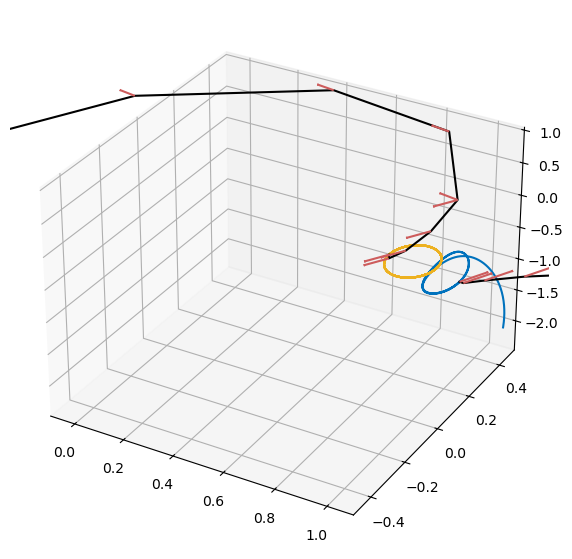

In [88]:
ax = udp_alpha.plot(pop_alpha.champion_x, show_gridpoints=False, show_throttles=True, show_midpoints=False)
ax.set_xlim(-0.1,1.1)
ax.set_ylim(-1/2,1/2)

In [89]:
x_init = pop_alpha.champion_x

In [90]:
nseg = nseg_old
nseg_old_solved = False

while nseg <= nseg_max:

    print('--------------------------')

    # Update udp_alpha
    udp_alpha.nseg = nseg

    prob_alpha = pg.problem(udp_alpha)
    prob_alpha.c_tol = 1e-6

    if nseg != nseg_old:
        alphas_old = best_x[8:8+nseg_old]
        t_old = pk.alpha2direct(alphas_old, best_x[-1])
        alphas_init = [0.0] * (nseg)
        t_init = [0.0] * (nseg)
        throttles_old = best_x[8+nseg_old:-1]
        throttles_init = [0.0] * (nseg * 3)
        for nn in range(nseg_old):
            # Alpha
            t_init[nn*2:nn*2+1] = (np.array(t_old[nn:nn+1])/2).tolist()
            t_init[nn*2+1:nn*2+2] = (np.array(t_old[nn:nn+1])/2).tolist()
            # Throttle
            throttles_init[nn*6:nn*6+3] = throttles_old[nn*3:nn*3+3]
            throttles_init[nn*6+3:nn*6+6] = throttles_old[nn*3:nn*3+3]
        alphas_init = pk.direct2alpha(t_init)[0]
        x_init = best_x[0:8].tolist() + alphas_init + throttles_init + [best_x[-1].item()]

    print(f'Testing Nseg {nseg}')
    total_time = 0.0

    ntotal = 10
    errs = []
    obj = []
    xs = []
    successes = []
    average_time = []

    for i in range(ntotal):
        time_start = time.time()
        
        if nseg != nseg_old and nseg_old_solved and i==0:
            # print('Using previous solution to initialise')
            pop_alpha = pg.population(prob_alpha, 0)
            pop_alpha.push_back(x_init)
        else:
            # print('Using equal spacing to initialise')
            pop_alpha = pg.population(prob_alpha, 1)
            x_tmp = pop_alpha.champion_x
            x_tmp[8:8+nseg] = pk.direct2alpha([1/nseg]*nseg)[0]
            pop_alpha.push_back(x_tmp)
        
        pop_alpha = algo.evolve(pop_alpha)
        
        time_end = time.time()
        average_time.append(time_end - time_start)
        total_time += time_end - time_start

        # print('err', np.linalg.norm(pop_alpha.champion_f[1:]), np.linalg.norm(pop_alpha.champion_f[1:4]), np.linalg.norm(pop_alpha.champion_f[4:7]))
        if(prob_alpha.feasibility_f(pop_alpha.champion_f)):
            print(".", end="")
            obj.append(pop_alpha.champion_x[1])
            xs.append(pop_alpha.champion_x)
            successes.append(1)
            # if nseg != nseg_old:
            #     break
        else:
            print("x", end ="")
    
    if len(obj)>0:
        print("\nBest mass is: ", np.max(obj))
        print(f"Total time to success: {total_time:.3f} seconds")
        print(f"mean time {np.mean(np.array(average_time)):.4g} s")
        print(f"median time {np.median(np.array(average_time)):.4g} s")
        print(f"std time {np.std(np.array(average_time)):.4g} s")
        best_idx = np.argmax(obj)
        nseg_old_solved = True
    else:
        xs = [pop_alpha.champion_x]
        best_idx = 0
        successes.append(0)
        obj.append(np.nan)
        print("\nNo solution found")
        nseg_old_solved = False

    best_x = xs[best_idx]

    # Update number of segments
    nseg_old = nseg
    if nseg < nseg_max:
        nseg = nseg * 2
    else:
        break

--------------------------
Testing Nseg 8
.xx...x.xx
Best mass is:  0.963523564252
Total time to success: 69.226 seconds
mean time 6.923 s
median time 6.762 s
std time 4.805 s


And we plot the trajectory found:

In [91]:
udp_alpha.pretty(best_x)


Low-thrust NEP transfer
Departure: [[1.1648780946517576, 0.0, -0.11145303634437023], [0.0, -0.20191923237095796, 0.0]]
Arrival: [[0.9517068403301521, 0.08833849525618821, 0.0], [0.39081262748026147, 0.18632512529205011, 0.0]]

Launch epoch: 0.00000
Arrival epoch: 5.00000
Time of flight (-): 5.00000 

Launch DV (-) 0.00000000 - [-0.0,-0.0,-0.0]
Arrival DV (-) 0.00000000 - [-0.0,-0.0,-0.0]
Final mass (mf/m0): 0.9635235642522395

Details on the low-thrust leg: (NEEDS fixing) 
Number of segments: 8
Number of fwd segments: 4
Number of bck segments: 4
Maximum thrust: 3.7637494800142672
Central body gravitational parameter: 0.01215058439470971
Specific impulse: 11.56499372183432

Time of flight: 5
Initial mass: 1
Final mass: 0.9635235642522395
State at departure: [[1.1648780946517576, 0, -0.11145303634437023], [0, -0.20191923237095796, 0]]
State at arrival: [[0.8983353548709259, 6.898359278839847e-15, 0], [3.261835620604638e-14, 0.4759116861682016, 0]]
Throttles values: [0.18703183252504396,

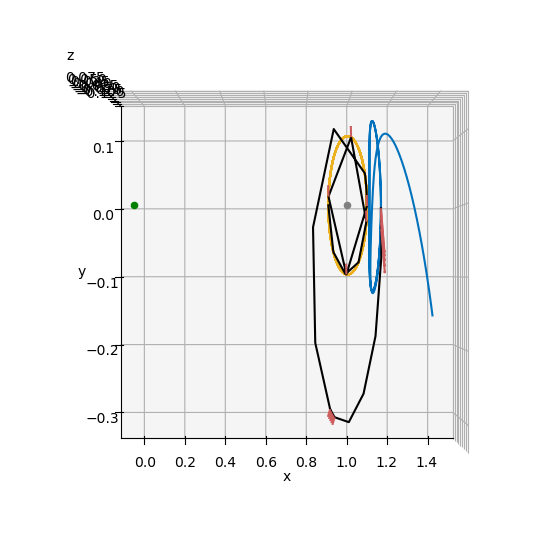

In [92]:
ax = udp_alpha.plot(best_x, show_gridpoints=False, show_throttles=True, show_midpoints=False)
# Making the axes nicer
ax.scatter(-mu, 0, 0, c="green", s=20)
ax.scatter(1-mu, 0, 0, c="gray", s=20)
# ax.set_xlim(-0.1,1.1)
# ax.set_ylim(-1/2,1/2)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.view_init(90,-90)
# ax.axis('off');

plt.savefig(os.path.join(folder_name, "trajectory.png"))


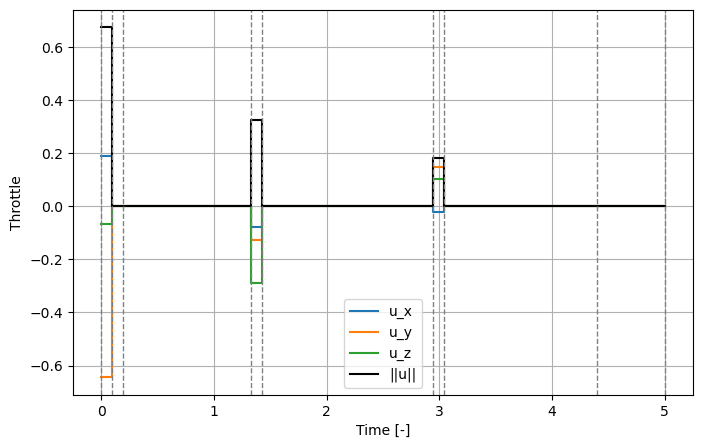

In [93]:
# Create time grid for throttle segments
# segment_times = np.linspace(0, tof, nseg)
segment_times = pk.alpha2direct(best_x[8:8+nseg], best_x[-1])
tgrid = np.cumsum(np.hstack(([0.0], segment_times)))

# Extract throttle values from the best solution
# tgrid = np.linspace(best_x[0], best_x[-1], int(len(best_x[8+nseg:-1])/3)+1)
throttle_profile = best_x[8+nseg:-1].reshape(int(len(best_x[8+nseg:-1])/3), 3)
# throttle_profile_ones = np.ones_like(throttle_profile)

# Objective: integral of the thrust
# obj = np.trapezoid(np.linalg.norm(throttle_profile[:, 0:3],axis=1),tgrid)/(tgrid[-1]-tgrid[0])
# obj = np.sum(np.linalg.norm(throttle_profile[:, 0:3],axis=1) * np.diff(tgrid)) / (tgrid[-1]-tgrid[0])

fig, ax = plt.subplots(figsize=(8, 5))

# Plot thrust profiles
ax.step(tgrid, np.hstack((throttle_profile[:, 0], throttle_profile[-1, 0])), label='u_x', where='post')
ax.step(tgrid, np.hstack((throttle_profile[:, 1], throttle_profile[-1, 1])), label='u_y', where='post')
ax.step(tgrid, np.hstack((throttle_profile[:, 2], throttle_profile[-1, 2])), label='u_z', where='post')
ax.step(
    tgrid,
    np.hstack((
        np.linalg.norm(throttle_profile[:, 0:3], axis=1),
        np.linalg.norm(throttle_profile[-1, 0:3])
    )),
    color='k', label='||u||', where='post'
)

# Add vertical grid lines
for t in tgrid:
    ax.axvline(x=t, color='gray', linestyle='--', linewidth=1.0)

# Labels, legend, and grid
ax.set_xlabel('Time [-]')
ax.set_ylabel('Throttle')
# ax.set_title(f'Thrust Profile: Obj {obj:.4f}')
ax.legend()
ax.grid(True)

# Save and show
plt.savefig(os.path.join(folder_name, "control.png"))
plt.show()


In [94]:
segment_times

[0.09502996098835083,
 0.09615349562096706,
 1.1366301443306737,
 0.09502996098835083,
 1.5204793758136157,
 0.09502996098835083,
 1.3562311751406047,
 0.6054159261290869]

In [95]:
import io
import sys

# Redirect stdout to capture udp_alpha.pretty(best_x) output
text_path = os.path.join(folder_name, "output.txt")
buffer = io.StringIO()
sys_stdout_backup = sys.stdout  # Backup real stdout
sys.stdout = buffer

try:
    udp_alpha.pretty(best_x)
finally:
    # Restore stdout
    sys.stdout = sys_stdout_backup

# Write captured output to file
output_text = buffer.getvalue()
with open(text_path, "w") as f:
    f.write(output_text)
print(f"Saved udp_alpha.pretty(best_x) output to: {text_path}")

Saved udp_alpha.pretty(best_x) output to: /Users/harry.holt/Documents/PostDoc_ACT/GTOC/benchmark-astrodynamics-sqp-scp/cr3bp_fixed_time_rdv/harry_results/yuri_mass_alpha/id3_sf_nd_const/output.txt


In [96]:
import shutil
# === Rename folder at the end ===
final_folder_name = f"{folder_name}_n{nseg:.0f}_o{best_x[1]:.4f}"
if not os.path.exists(final_folder_name):
    shutil.move(folder_name, final_folder_name)
print(f"Renamed folder to: {final_folder_name}")

Renamed folder to: /Users/harry.holt/Documents/PostDoc_ACT/GTOC/benchmark-astrodynamics-sqp-scp/cr3bp_fixed_time_rdv/harry_results/yuri_mass_alpha/id3_sf_nd_const_n8_o0.9635
